# Introduction
For my final capstone, I will create a model that processes a piece of an xray of breast tissue and classifies whether or not image contains cancerous tissue. Breast cancer is the most common form of cancer in women, contributing just over a quarter of diagnoses, so having the ability to improve the timeline and accuracy of a diagnosis would greatly improve the disease.

My solution will be valuable because it will capture this information more quickly and accurately than a person could. It would be a model used by hospitals and other healthcare organizations to identify the presence of cancerous tissue. This model would be able to see abnormalities at a much earlier stage which would allow treatment to commence earlier and have a higher success rate.  Ideally, the model could be adjusted for other types of tumor or disease classifications.

I will use the [Breast Histopathology Images dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images) from the National Library of Medicine. There are 277,524 pieces of 162 images scanned which should be plenty of data to learn from. The data is imbalanced - there is a 34/66 split between the classes. To handle this, I will likely choose a random subset of the images marked IDC negative to ensure I have a balanced dataset.

Because the data is images, I don't believe it doesn't to be cleaned and prepped - it will simply be imported into Python and converted into a dataframe in which each column represents a pixel. I will then use dimensionality reduction and unsupervised learning to obtain in-depth knowledge about the information the data provides and visualize any patterns or clusters the information may fall into. I will need to do some research on how to use supervised learning on image processing/classification as it is not yet clear to me how to do so. Finally, I will use neural networks, and CNN in particular, to classify the scans and create a model that can take an un-labeled scan and report whether or not cancerous tissue is present. 

I anticipate importing and processing the images as well as tuning the parameters in the neural networks to be the biggest challenges I'll face. I plan on spending the majority of my time on these two items. For the most part, I should be able to recycle code from previous projects which should expedite my prepping and modeling. I'll do additional research on how best to use neural networks for image classification in an effort to obtain the best model.


In [1]:
import os
os.chdir('C:\\Users\\M246047\\Documents\\Python')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import re


# Importing/showing the files
from zipfile import ZipFile
import cv2
from glob import glob
from random import sample
import skimage.io as io

# Preprocessing/Cleaning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import scipy.stats as stats

# Import various componenets for model building
import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import History

# Dimensionality Reduction & Unsupervised Learning
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn import datasets, metrics
from sklearn.neural_network import BernoulliRBM
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage as lnkg
from sklearn.neural_network import MLPClassifier


# Import the backend
from keras import backend as K
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Data Augmentation
import argparse



# Set random seed
np.random.seed(0)

Using TensorFlow backend.


In [4]:
import skimage.io as io

In [2]:
io.imshow('C:\\Users\\M246047\\Documents\\Python\\8863_idx5_x1001_y1551_class1.png')

# The Images

Below we see samples of cancerous and non-cancerous tissue. The images containing cancer generally appear to be darker and more densely packed, a distinction that a model may use to classify an image. 


Why are these printing two sets of each?

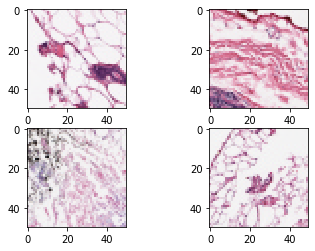

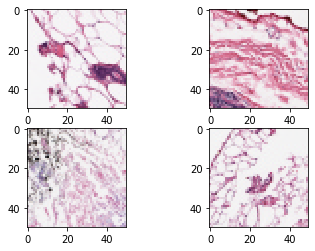

In [5]:
non_cancerous_images = io.imread_collection('88*_class0.png')
io.imshow_collection(non_cancerous_images)

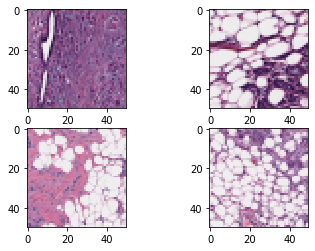

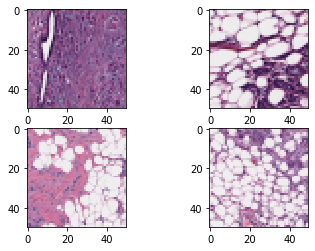

In [163]:
cancerous_images = io.imread_collection('88*_class1.png')
io.imshow_collection(cancerous_images)

Slides With Cancerous Tissue
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


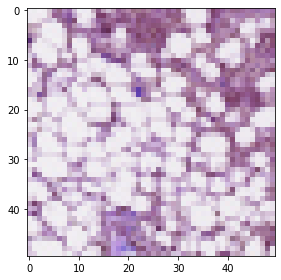

In [6]:
cancerous_images = ['8863_idx5_x1001_y1551_class1', '8864_idx5_x1501_y2551_class1',
                    '8865_idx5_x1701_y651_class1', '8867_idx5_x501_y1051_class1']
non_cancerous_images = ['8863_idx5_x151_y1401_class0', '8864_idx5_x101_y2251_class0',
                       '8865_idx5_x301_y1151_class0', '8867_idx5_x151_y201_class0']

# img = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\8863_idx5_x1001_y1551_class1.png')  
# cv2.imshow('image', img)

print('Slides With Cancerous Tissue')
# Read RGB image 
for image in cancerous_images:
    img = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\'+image+'.png') 
    print(type(img))
    io.imshow(img) 
  

# print('Slides Without Cancerous Tissue')
# # Read RGB image 
# for image in non_cancerous_images:
#     img = cv2.imread(image+'.png')  
#     cv2.imshow('image', img) 


# Importing and Prepping the Data

I gravely underestimated how difficult this task would be. I had an initial folder for the data which contained folders for each patient. Each of these folders contained two folders labeled 0 and 1 which contained images with or without cancerous tissue, depending on the folder. At first, I tried to iterate through each patient folder to grab the 0 and 1 folders within, and iterate through each of those folder to grab each image to import it, but was unable to do so. In the end I mapped to the initial folder and iterated through each patient folder to create arrays containing the pixel data for each image. Using the length of these arrays, I was able to create an array with the target values, with 0 for a scan without cancerous tissue and 1 for a scan with.

The data had a various number of scans from 227? patients for a total of 227,000? scans. The data was very imbalanced in favor of tissue without cancer - in order to combat this, once the scans were imported, I took an equal number samples of the scans without signs of cancer as scans with cancer to have an even split. 



In [6]:
list_of_dicts = []
for patient in glob('C:\\Users\\M246047\\Documents\\Python\\breast-histopathology-images\\*'):
    no_cancer = len([x for x in glob(patient + '\\0\\*')])
    cancer = len([x for x in glob(patient + '\\1\\*')])
    list_of_dicts.append({'patient': patient, 'cancer': cancer, 'no_cancer': no_cancer})
df = pd.DataFrame.from_dict(list_of_dicts)

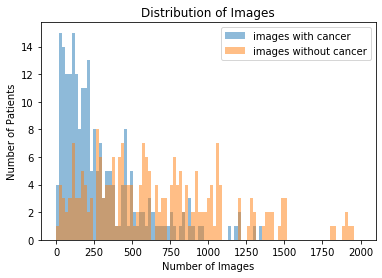

In [3]:
images_with = df['cancer']
images_without = df['no_cancer']
bins = np.linspace(0, 2000, 100)
plt.hist(images_with, bins, alpha=0.5, label='images with cancer')
plt.hist(images_without, bins, alpha=0.5, label='images without cancer')
plt.legend(loc='upper right')
plt.title('Distribution of Images')
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.show()


# Individual Patients - Importing the Images by Folder

Because there was so much data, I chose to focus on three patients, using a fourth as the validation set, when first creating my models so as to expedite the process. 

In [7]:
images_0_8863 = []
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\8863\\0'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\8863\\0\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(1, 50, 50)
            images_0_8863.append(image_data)
            
images_0_8863 = np.asarray(images_0_8863)    
print('There are {} images'.format(len(images_0_8863)))
print('The type of the data is', type(images_0_8863))
print('The shape of the data is', images_0_8863.shape)
images_0_8863_class = np.zeros((len(images_0_8863),), dtype=int)

There are 768 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (768, 50, 50)


In [8]:
# Creating a list of image names
images_1_8863 = []
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\8863\\1'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\8863\\1\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(2500,)
            images_1_8863.append(image_data)
            
images_1_8863 = np.asarray(images_1_8863)
print('There are {} images'.format(len(images_1_8863)))
print('The type of the data is', type(images_1_8863))
print('The shape of the data is', images_1_8863.shape)
images_1_8863_class = np.ones((len(images_1_8863),), dtype=int)

There are 207 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (207, 50, 50)


In [9]:
images_0_8864 = []
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\8864\\0'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\8864\\0\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(2500,)
            images_0_8864.append(image_data)
            
images_0_8864 = np.asarray(images_0_8864)    
print('There are {} images'.format(len(images_0_8864)))
print('The type of the data is', type(images_0_8864))
print('The shape of the data is', images_0_8864.shape)
images_0_8864_class = np.zeros((len(images_0_8864)), dtype=int)

There are 730 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (730, 50, 50)


In [10]:
# Creating a list of image names
images_1_8864 = []
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\8864\\1'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\8864\\1\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(2500,)
            images_1_8864.append(image_data)
            
images_1_8864 = np.asarray(images_1_8864)
print('There are {} images'.format(len(images_1_8864)))
print('The type of the data is', type(images_1_8864))
print('The shape of the data is', images_1_8864.shape)
images_1_8864_class = np.ones((len(images_1_8864),), dtype=int)

There are 326 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (326, 50, 50)


In [11]:
images_0_8865 = []
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\8865\\0'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\8865\\0\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(2500,)
            images_0_8865.append(image_data)
            
images_0_8865 = np.asarray(images_0_8865)    
print('There are {} images'.format(len(images_0_8865)))
print('The type of the data is', type(images_0_8865))
print('The shape of the data is', images_0_8865.shape)
images_0_8865_class = np.zeros((len(images_0_8865)), dtype=int)

There are 657 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (657, 50, 50)


In [12]:
# Creating a list of image names
images_1_8865 = []
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\8865\\1'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\8865\\1\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(2500,)
            images_1_8865.append(image_data)
            
images_1_8865 = np.asarray(images_1_8865)
print('There are {} images'.format(len(images_1_8865)))
print('The type of the data is', type(images_1_8865))
print('The shape of the data is', images_1_8865.shape)
images_1_8865_class = np.ones((len(images_1_8865),), dtype=int)

There are 55 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (55, 50, 50)


In [13]:
images_0_8867 = []
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\8867\\0'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\8867\\0\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(2500,)
            images_0_8867.append(image_data)
            
images_0_8867 = np.asarray(images_0_8867)    
print('There are {} images'.format(len(images_0_8867)))
print('The type of the data is', type(images_0_8867))
print('The shape of the data is', images_0_8867.shape)
images_0_8867_class = np.zeros((len(images_0_8867)), dtype=int)

There are 1478 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (1478, 50, 50)


In [14]:
# Creating a list of image names
images_1_8867 = []
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\8867\\1'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\8867\\1\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(2500,)
            images_1_8867.append(image_data)
            
images_1_8867 = np.asarray(images_1_8867)
print('There are {} images'.format(len(images_1_8867)))
print('The type of the data is', type(images_1_8867))
print('The shape of the data is', images_1_8867.shape)
images_1_8867_class = np.ones((len(images_1_8867),), dtype=int)

There are 162 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (162, 50, 50)


## Defining Training & Testing Sets and Normalizing the Data

Here I combine the non-cancerous images and target arrays with the cancerous data for a complete dataset.

## One Patient

In [15]:
# Create x_train and y_train
x1_train = np.append(images_0_8863, images_1_8863, axis=0)
y1_train = np.append(images_0_8863_class, images_1_8863_class, axis=0)
print('x_train shape:',x1_train.shape)
print('y_train shape:',y1_train.shape)

# Create x_test and y_test
x1_test = np.append(images_0_8865, images_1_8865, axis=0)
y1_test = np.append(images_0_8865_class, images_1_8865_class, axis=0)

print('x1_test shape:', x1_test.shape)
print('y1_test shape: ', y1_test.shape)

x_train shape: (975, 50, 50)
y_train shape: (975,)
x1_test shape: (712, 50, 50)
y1_test shape:  (712,)


In [59]:
# Convert to float32 for type consistency
x1_train = x1_train.astype('float32')
x1_test = x1_test.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
x1_train /= 255
x1_test /= 255
print('x1_train shape:', x1_train.shape)
print('x1_test shape:', x1_test.shape)
# Convert class vectors to binary class matrices
# So instead of one column with two values, create two binary columns
y1_train = keras.utils.to_categorical(y1_train, 2)
y1_test = keras.utils.to_categorical(y1_test, 2)

x1_train shape: (975, 50, 50)
x1_test shape: (712, 50, 50)


In [35]:
# Per Yunus: first of all keep your images as (1,50,50) not as (1,2500).
img_rows = 50
img_cols = 50
if K.image_data_format() == 'channels_first':
    x1_train = x1_train.reshape(x1_train.shape[0], 1, img_rows, img_cols)
    x1_test = x1_test.reshape(x1_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x1_train = x1_train.reshape(x1_train.shape[0], img_rows, img_cols, 1)
    x1_test = x1_test.reshape(x1_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

### CNN Model with Relu

This model is a decent start with a test accuracy of 0.923, though I'm not sure why the test loss is so large at 20.06.

In [36]:
# Building the Model
num_classes = 2
model_cnn_relu = Sequential()
# First convolutional layer, note the specification of shape
model_cnn_relu.add(Conv2D(32, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))
model_cnn_relu.add(Conv2D(64, (4, 4), activation='relu', kernel_regularizer=regularizers.l1(0.75)))

model_cnn_relu.add(Dropout(0.5))
model_cnn_relu.add(Flatten())
model_cnn_relu.add(Dense(num_classes, activation='softmax'))


# model_cnn_relu.add(MaxPooling2D(pool_size=(2, 2))
# model_cnn_relu.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.75)))
# model_cnn_relu.add(Dropout(0.5))


model_cnn_relu.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn_relu.fit(x1_train, y1_train,
          batch_size=200,
          epochs=10,
          verbose=1,
          validation_data=(x1_test, y1_test))
score = model_cnn_relu.evaluate(x1_test, y1_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 975 samples, validate on 712 samples
Epoch 1/10
975/975 [==============================] - 8s 8ms/step - loss: 705.9895 - accuracy: 0.6379 - val_loss: 605.5942 - val_accuracy: 0.9228
Epoch 2/10
975/975 [==============================] - 7s 8ms/step - loss: 546.7242 - accuracy: 0.7877 - val_loss: 458.0365 - val_accuracy: 0.9228
Epoch 3/10
975/975 [==============================] - 7s 8ms/step - loss: 406.7642 - accuracy: 0.7877 - val_loss: 330.2795 - val_accuracy: 0.9228
Epoch 4/10
975/975 [==============================] - 7s 8ms/step - loss: 287.0601 - accuracy: 0.7877 - val_loss: 223.1645 - val_accuracy: 0.9228
Epoch 5/10
975/975 [==============================] - 7s 8ms/step - loss: 188.2889 - accuracy: 0.7877 - val_loss: 137.7992 - val_accuracy: 0.9228
Epoch 6/10
975/975 [==============================] - 7s 8ms/step - loss: 111.8055 - accuracy: 0.7867 - val_loss: 75.3065 - val_accuracy: 0.9228
Epoch 7/10
975/975 [==============================] - 8s 8ms/step - loss: 58.29

## Two Patients

In [49]:
# Create x_train and y_train

x2_train = np.concatenate((images_0_8863, images_1_8863, images_0_8864, images_1_8864), axis=0)
y2_train = np.concatenate((images_0_8863_class, images_1_8863_class, images_0_8864_class, images_1_8864_class), axis=0)
print('x2_train shape:',x2_train.shape)
print('y2_train shape:',y2_train.shape)

# Create x_test and y_test
x2_test = np.append(images_0_8865, images_1_8865, axis=0)
y2_test = np.append(images_0_8865_class, images_1_8865_class, axis=0)

print('x2_test shape:', x2_test.shape)
print('y2_test shape: ', y2_test.shape)

(768, 50, 50)
(207, 50, 50)
(768,)
(207,)
(657, 50, 50)
(55, 50, 50)
(657,)
(55,)
x2_train shape: (2031, 50, 50)
y2_train shape: (2031,)
x2_test shape: (712, 50, 50)
y2_test shape:  (712,)


In [61]:
# Convert to float32 for type consistency
x2_train = x2_train.astype('float32')
x2_test = x2_test.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
x2_train /= 255
x2_test /= 255

# Convert class vectors to binary class matrices
# So instead of one column with two values, create two binary columns
y2_train = keras.utils.to_categorical(y2_train, 2)
y2_test = keras.utils.to_categorical(y2_test, 2)

print(x2_train.shape)
print(y2_train.shape)
print(x2_test.shape)
print(y2_test.shape)

(2031, 50, 50, 1)
(2031, 2)
(712, 50, 50, 1)
(712, 2)


In [62]:
# Per Yunus: first of all keep your images as (1,50,50) not as (1,2500).
img_rows = 50
img_cols = 50
if K.image_data_format() == 'channels_first':
    x2_train = x2_train.reshape(x2_train.shape[0], 1, img_rows, img_cols)
    x2_test = x2_test.reshape(x2_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x2_train = x2_train.reshape(x2_train.shape[0], img_rows, img_cols, 1)
    x2_test = x2_test.reshape(x2_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

### CNN Model with Relu

Neither the test accuracy nor loss have changed, indicating this could be a good model for the data, or that the images are simply very similar.



In [66]:
# Building the Model
num_classes = 2
model_cnn_relu = Sequential()
# First convolutional layer, note the specification of shape
model_cnn_relu.add(Conv2D(32, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))
model_cnn_relu.add(Conv2D(64, (4, 4), activation='relu', kernel_regularizer=regularizers.l1(0.75)))

model_cnn_relu.add(Dropout(0.5))
model_cnn_relu.add(Flatten())
model_cnn_relu.add(Dense(num_classes, activation='softmax'))


# model_cnn_relu.add(MaxPooling2D(pool_size=(2, 2))
# model_cnn_relu.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.75)))
# model_cnn_relu.add(Dropout(0.5))


model_cnn_relu.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn_relu.fit(x2_train, y2_train,
          batch_size=200,
          epochs=10,
          verbose=1,
          validation_data=(x2_test, y2_test))
score = model_cnn_relu.evaluate(x2_test, y2_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2031 samples, validate on 712 samples
Epoch 1/10
2031/2031 [==============================] - 15s 7ms/step - loss: 620.4244 - accuracy: 0.6637 - val_loss: 429.5169 - val_accuracy: 0.9228
Epoch 2/10
2031/2031 [==============================] - 15s 8ms/step - loss: 319.7446 - accuracy: 0.7725 - val_loss: 186.8349 - val_accuracy: 0.9228
Epoch 3/10
2031/2031 [==============================] - 15s 8ms/step - loss: 120.3364 - accuracy: 0.7701 - val_loss: 49.8627 - val_accuracy: 0.9228
Epoch 4/10
2031/2031 [==============================] - 15s 7ms/step - loss: 29.2452 - accuracy: 0.7617 - val_loss: 19.5548 - val_accuracy: 0.9228
Epoch 5/10
2031/2031 [==============================] - 15s 7ms/step - loss: 19.9335 - accuracy: 0.7376 - val_loss: 19.8273 - val_accuracy: 0.9228
Epoch 6/10
2031/2031 [==============================] - 15s 7ms/step - loss: 20.2097 - accuracy: 0.7376 - val_loss: 20.0834 - val_accuracy: 0.9228
Epoch 7/10
2031/2031 [==============================] - 15s 7ms/st

## Three Patients

In [16]:
# Create x_train and y_train

x3_train = np.concatenate((images_0_8863, images_1_8863, images_0_8864, images_1_8864, images_0_8865, images_1_8865), axis=0)
y3_train = np.concatenate((images_0_8863_class, images_1_8863_class, images_0_8864_class, images_1_8864_class, images_0_8865_class, images_1_8865_class), axis=0)
print('x3_train shape:',x3_train.shape)
print('y3_train shape:',y3_train.shape)

# Create x_test and y_test
x3_test = np.append(images_0_8867, images_1_8867, axis=0)
y3_test = np.append(images_0_8867_class, images_1_8867_class, axis=0)

print('x3_test shape:', x3_test.shape)
print('y3_test shape: ', y3_test.shape)

x3_train shape: (2743, 50, 50)
y3_train shape: (2743,)
x3_test shape: (1640, 50, 50)
y3_test shape:  (1640,)


In [17]:
# Convert to float32 for type consistency
x3_train = x3_train.astype('float32')
x3_test = x3_test.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
x3_train /= 255
x3_test /= 255

# Convert class vectors to binary class matrices
# So instead of one column with two values, create two binary columns
y3_train = keras.utils.to_categorical(y3_train, 2)
y3_test = keras.utils.to_categorical(y3_test, 2)

print(x3_train.shape)
print(y3_train.shape)
print(x3_test.shape)
print(y3_test.shape)

(2743, 50, 50)
(2743, 2)
(1640, 50, 50)
(1640, 2)


In [18]:
# Per Yunus: first of all keep your images as (1,50,50) not as (1,2500).
img_rows = 50
img_cols = 50
if K.image_data_format() == 'channels_first':
    x3_train = x3_train.reshape(x3_train.shape[0], 1, img_rows, img_cols)
    x3_test = x3_test.reshape(x3_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x3_train = x3_train.reshape(x3_train.shape[0], img_rows, img_cols, 1)
    x3_test = x3_test.reshape(x3_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

### CNN Model with Relu

The test metrics have slightly decreased in performance to a loss of 21.44 and accuracy of 0.90. 

In [147]:
# Building the Model
num_classes = 2
patients_3 = Sequential()
# First convolutional layer, note the specification of shape
patients_3.add(Conv2D(32, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))
patients_3.add(Conv2D(64, (4, 4), activation='relu', kernel_regularizer=regularizers.l1(0.75)))

patients_3.add(Dropout(0.5))
patients_3.add(Flatten())
patients_3.add(Dense(num_classes, activation='softmax'))


# model_cnn_relu.add(MaxPooling2D(pool_size=(2, 2))
# model_cnn_relu.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.75)))
# model_cnn_relu.add(Dropout(0.5))


patients_3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

patients_3.fit(x3_train, y3_train,
          batch_size=200,
          epochs=5,
          verbose=1,
          validation_data=(x3_test, y3_test))
score = patients_3.evaluate(x3_test, y3_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2743 samples, validate on 1640 samples
Epoch 1/5
2743/2743 [==============================] - 25s 9ms/step - loss: 567.8677 - accuracy: 0.7339 - val_loss: 352.8241 - val_accuracy: 0.9012
Epoch 2/5
2743/2743 [==============================] - 25s 9ms/step - loss: 223.0183 - accuracy: 0.7510 - val_loss: 98.4054 - val_accuracy: 0.9030
Epoch 3/5
2743/2743 [==============================] - 24s 9ms/step - loss: 47.8620 - accuracy: 0.8035 - val_loss: 19.8688 - val_accuracy: 0.9012
Epoch 4/5
2743/2743 [==============================] - 24s 9ms/step - loss: 19.9202 - accuracy: 0.7463 - val_loss: 19.8880 - val_accuracy: 0.9012
Epoch 5/5
2743/2743 [==============================] - 24s 9ms/step - loss: 20.1104 - accuracy: 0.7856 - val_loss: 20.2902 - val_accuracy: 0.9012
Test loss: 20.290162351654796
Test accuracy: 0.9012194871902466


### Plotting the Loss and Accuracy


In [25]:
print(patients_3.history.history['val_accuracy'])
print((patients_3.history.history['accuracy']))

[0.9012194871902466, 0.9012194871902466, 0.09878049045801163, 0.9012194871902466, 0.9012194871902466]
[0.72110826, 0.79584396, 0.8034998, 0.70761937, 0.7856362]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


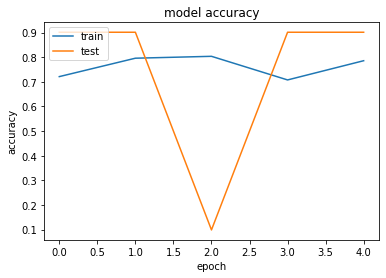

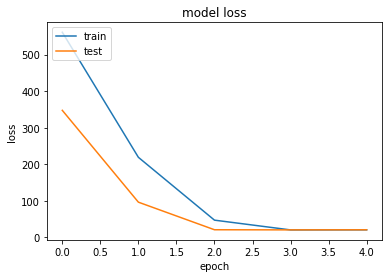

In [24]:
print(patients_3.history.history.keys())
# summarize history for accuracy
plt.plot(patients_3.history.history['accuracy'])
plt.plot(patients_3.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(patients_3.history.history['loss'])
plt.plot(patients_3.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Confusion Matrix

While the accuracy for these models has been high at around 0.9, it's clear from the confusion matrix below that the model has simply been assigning each image to zero, or no cancer. Because the data was so imbalanced, according to the loss and accuracy this is a good model, but it's realistically terrible.

In [148]:
patients_3_predictions = patients_3.predict(x_test)
y_pred = (patients_3_predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[11695,     0],
       [11695,     0]], dtype=int64)

# Questions
- raw images (one with cancer, one without)
- same images before they're fed into the neural network
- plot type 1 and 2 errors - how would this help without a feature to plot against?
- plot errors - how would I do this, what would it help?
- how to use feature importance in keras?

# All the Data

Clearly, the previous models were utterly useless. Hopefully importing much more data and sampling the images without cancer to be equal in number to the images with cancer will provide a better outcome.

## Creating the Training and Testing Data

In [109]:
X_1 = [] # training data labeled 1
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\1'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\1\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(1, 50, 50)
            X_1.append(image_data)
            
X_1 = np.asarray(X_1)    
print('There are {} images'.format(len(X_1)))
print('The type of the data is', type(X_1))
print('The shape of the data is', X_1.shape)
X_1_target = np.ones((len(X_1),), dtype=int)
X_0_target = np.ones((len(X_1),), dtype=int)


There are 27671 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (27671, 50, 50)


In [110]:
X_0 = [] # training data labeled 0
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\0'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\0\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(1, 50, 50)
            X_0.append(image_data)
            
X_0 = np.asarray(X_0)
print('There are {} images'.format(len(X_0)))
print('The type of the data is', type(X_0))
print('The shape of the data is', X_0.shape)
X_0 = X_0[:(len(X_1)),:,:]
print('There are {} images of non-cancerous tissue once sampled'.format(len(X_0)))

There are 79600 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (79600, 50, 50)
There are 27671 images once sampled


In [111]:
X_1_test = [] # testing data labeled 1
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\1_test'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\1_test\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(1, 50, 50)
            X_1_test.append(image_data)
            
X_1_test = np.asarray(X_1_test)    
print('There are {} images'.format(len(X_1_test)))
print('The type of the data is', type(X_1_test))
print('The shape of the data is', X_1_test.shape)
X_1_test_target = np.ones((len(X_1_test),), dtype=int)
X_0_test_target = np.zeros((len(X_1_test),), dtype=int)

There are 11695 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (11695, 50, 50)


In [112]:
X_0_test = [] # testing data labeled 0
for root, dirs, files in os.walk('C:\\Users\\M246047\\Documents\\Python\\0_test'):
    for filename in files:
        image_data = cv2.imread('C:\\Users\\M246047\\Documents\\Python\\0_test\\'+filename, 0)
#         print(filename)
#         print(image_data.shape)
        if image_data.shape==(50,50):
#             image_data = image_data.reshape(1, 50, 50)
            X_0_test.append(image_data)
            
X_0_test = np.asarray(X_0_test)    
print('There are {} images'.format(len(X_0_test)))
print('The type of the data is', type(X_0_test))
print('The shape of the data is', X_0_test.shape)
X_0_test = X_0_test[:(len(X_1_test)),:,:]
print('There are {} images of non-cancerous tissue once sampled'.format(len(X_0_test)))

There are 23173 images
The type of the data is <class 'numpy.ndarray'>
The shape of the data is (23173, 50, 50)
There are 11695 images once sampled


## Defining Training & Testing Sets and Normalizing the Data

In [113]:
# Create x_train and y_train
x_train = np.append(X_1, X_0, axis=0)
y_train = np.append(X_1_target, X_0_target, axis=0)
print('x_train shape:',x_train.shape)
print('y_train shape:',y_train.shape)

# Create x_test and y_test
x_test = np.append(X_1_test, X_0_test, axis=0)
y_test = np.append(X_1_test_target, X_0_test_target, axis=0)

print('x_test shape:', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape: (55342, 50, 50)
y_train shape: (55342,)
x_test shape: (23390, 50, 50)
y_test shape:  (23390,)


In [114]:
# Convert to float32 for type consistency
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize values to 1 from 0 to 255 (256 values of pixels)
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
# Convert class vectors to binary class matrices
# So instead of one column with 10 values, create 10 binary columns
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

x_train shape: (55342, 50, 50)
x_test shape: (23390, 50, 50)
y_train shape: (55342,)
y_test shape: (23390,)


In [115]:
# Per Yunus: first of all keep your images as (1,50,50) not as (1,2500).
img_rows = 50
img_cols = 50
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Using XGBoost as a Starting Point

I'm using XGBoost as a starting point to see how the metrics can improve over the course of testing. This model is clearly overfitting as much as possible, with a score of 1 for the training sets and 0.5 for the testing sets, indicating it's simply randomly assigning labels on the testing set.

In [167]:
x_train_xgb = x_train.reshape(55342, 2500)
x_test_xgb = x_test.reshape(23390, 2500)
y_train_xgb = np.append(X_1_target, X_0_target, axis=0)
y_test_xgb = np.append(X_1_test_target, X_0_test_target, axis=0)
print(x_train_xgb.shape)
print(y_train_xgb.shape)

(55342, 2500)
(55342,)


In [169]:
# defining the model
xgb_clf = xgboost.XGBClassifier()
xgb_clf = xgb_clf.fit(x_train_xgb, y_train_xgb)

print('Training score:', xgb_clf.score(x_train_xgb, y_train_xgb))
print('Testing score:', xgb_clf.score(x_test_xgb, y_test_xgb))

Training score: 1.0
Testing score: 0.5


In [166]:
xgb_clf_predictions = xgb_clf.predict(x_test_xgb)
y_pred = (xgb_clf_predictions > 0.5)
matrix = metrics.confusion_matrix(y_test_xgb.argmax(), y_pred.argmax())
matrix

TypeError: Singleton array 0 cannot be considered a valid collection.

# Creating the Neural Networks

## Model 1: Simple Sequential

This model grossly overfits the data. 

In [71]:
# Start with a simple sequential model
model_seq = Sequential()
model_seq.add(Flatten())
# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_seq.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.75)))
# Dropout layers remove features and fight overfitting
model_seq.add(Dropout(0.5))
model_seq.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.75)))
model_seq.add(Dropout(0.5))
# End with a number of units equal to the number of classes we have for our outcome
model_seq.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l1(0.75)))



# Compile the model to put it all together.
model_seq.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model_seq.fit(x_train, y_train,
                    batch_size=500,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model_seq.evaluate(x_test, y_test, verbose=0)
model_seq.summary()
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 55342 samples, validate on 23390 samples
Epoch 1/10
55342/55342 [==============================] - 2s 28us/step - loss: 516.1746 - accuracy: 0.8248 - val_loss: 132.1763 - val_accuracy: 0.5000
Epoch 2/10
55342/55342 [==============================] - 1s 26us/step - loss: 83.2010 - accuracy: 1.0000 - val_loss: 62.7764 - val_accuracy: 0.5000
Epoch 3/10
55342/55342 [==============================] - 1s 25us/step - loss: 62.0000 - accuracy: 1.0000 - val_loss: 62.1110 - val_accuracy: 0.5000
Epoch 4/10
55342/55342 [==============================] - 1s 25us/step - loss: 61.8055 - accuracy: 1.0000 - val_loss: 62.2232 - val_accuracy: 0.5000
Epoch 5/10
55342/55342 [==============================] - 1s 25us/step - loss: 61.7437 - accuracy: 1.0000 - val_loss: 62.2420 - val_accuracy: 0.5000
Epoch 6/10
55342/55342 [==============================] - 1s 26us/step - loss: 61.6899 - accuracy: 1.0000 - val_loss: 62.3128 - val_accuracy: 0.5000
Epoch 7/10
55342/55342 [==============================

## Model 2: Convolutional Neural Network with Relu Activation

In [82]:
# Building the Model
num_classes = 2
model_cnn_relu = Sequential()
# First convolutional layer, note the specification of shape
model_cnn_relu.add(Conv2D(32, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))
model_cnn_relu.add(MaxPooling2D(pool_size=(2, 2)))                  
model_cnn_relu.add(Conv2D(64, (4, 4), activation='relu', kernel_regularizer=regularizers.l1(0.75)))
model_cnn_relu.add(MaxPooling2D(pool_size=(2, 2)))
# model_cnn_relu.add(Dropout(0.5))
model_cnn_relu.add(Flatten())
model_cnn_relu.add(Dense(num_classes, activation='softmax'))


# model_cnn_relu.add(MaxPooling2D(pool_size=(2, 2))
# model_cnn_relu.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.75)))
# model_cnn_relu.add(Dropout(0.5))


model_cnn_relu.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn_relu.fit(x_train, y_train,
          batch_size=200,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

model_cnn_relu_predictions = model_cnn_relu.predict_classes(x_test)
model_cnn_relu_score = model_cnn_relu.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 55342 samples, validate on 23390 samples
Epoch 1/5
55342/55342 [==============================] - 93s 2ms/step - loss: 59.9453 - accuracy: 0.9999 - val_loss: 28.6561 - val_accuracy: 0.5000
Epoch 2/5
55342/55342 [==============================] - 98s 2ms/step - loss: 25.5241 - accuracy: 1.0000 - val_loss: 33.8560 - val_accuracy: 0.5000
Epoch 3/5
55342/55342 [==============================] - 105s 2ms/step - loss: 29.3423 - accuracy: 1.0000 - val_loss: 37.6256 - val_accuracy: 0.5000
Epoch 4/5
55342/55342 [==============================] - 117s 2ms/step - loss: 32.7154 - accuracy: 1.0000 - val_loss: 41.1177 - val_accuracy: 0.5000
Epoch 5/5
55342/55342 [==============================] - 108s 2ms/step - loss: 35.7714 - accuracy: 1.0000 - val_loss: 44.0471 - val_accuracy: 0.5000
Test loss: 44.04709434688677
Test accuracy: 0.5


### Plotting the Loss and Accuracy

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


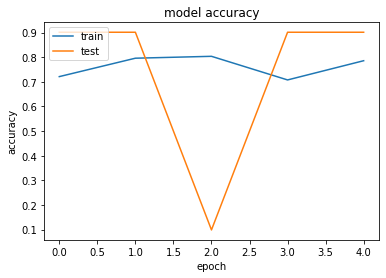

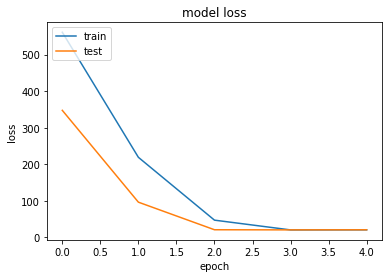

In [66]:
# list all data in history
print(model_cnn_relu.history.history.keys())
# summarize history for accuracy
plt.plot(model_cnn_relu.history.history['accuracy'])
plt.plot(model_cnn_relu.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_cnn_relu.history.history['loss'])
plt.plot(model_cnn_relu.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [146]:
model_cnn_relu_predictions = model_cnn_relu.predict(x_test)
y_pred = (model_cnn_relu_predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[    0, 11695],
       [    0, 11695]], dtype=int64)

### Plotting the Error Types

In [97]:
test_with_preds.labels.value_counts()

1    11695
0    11695
Name: labels, dtype: int64

In [95]:
test_with_preds.preds

0        1
1        1
2        1
3        1
4        1
        ..
23385    1
23386    1
23387    1
23388    1
23389    1
Name: preds, Length: 23390, dtype: int64

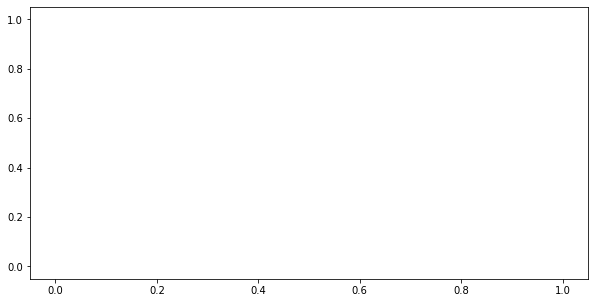

In [92]:
test_with_preds = pd.DataFrame(data=x_test_xgb)#, columns=["column1", "column2"])
test_with_preds['labels'] = y_test_xgb
test_with_preds['preds'] = predictions
fig = plt.figure(figsize=(10, 5))

# find false negatives (Type II errors)
sns.scatterplot(test_with_preds.loc[(test_with_preds.preds == 0) &
            (test_with_preds.loc[:,0] == 1), 'labels'],
               test_with_preds.loc[(test_with_preds.preds == 1) &
            (test_with_preds.loc[:,0] == 0), 'labels'],
                color='brown',
                alpha=.3,
                edgecolor='none',
                label="False Negatives")
plt.show()


# # find false negatives (Type II errors)
# sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
#             (df_with_pred.loc[:,0] == False), 'contractor_100k_ct'],
#                df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
#             (df_with_pred.loc[:,0] == False), 'employee_tot_ct'],
#                 color='brown',
#                 alpha=.3,
#                 edgecolor='none',
#                 label="False Negatives")

# # find false positives (Type I errors)
# sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == False) &
#             (df_with_pred.loc[:,0] == True), 'contractor_100k_ct'],
#                df_with_pred.loc[(df_with_pred.TARGET_FEATURE == False) &
#             (df_with_pred.loc[:,0] == True), 'exp_PCA'],
#                 color='orange',
#                 alpha=.8,
#                 edgecolor='none',
#               label="False Positives")

# sns.scatterplot(df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
#             (df_with_pred.loc[:,0] == True), 'contractor_100k_ct'],
#                df_with_pred.loc[(df_with_pred.TARGET_FEATURE == True) &
#             (df_with_pred.loc[:,0] == True), 'exp_PCA'],
#                 color='darkgreen',
#                 alpha=1,
#                 edgecolor='none',
#               label="True Positives")

# plt.title('Type I & Type II Error Comparison - Contractor Count vs. Expenses', fontsize=15)
# # plt.savefig('visualizations/cont_count_expenses_type_I_type_II.png');

## Model 3: CNN With TanH Activation


In [79]:
# Building the Model
num_classes = 2
model_cnn_tanh = Sequential()
# First convolutional layer, note the specification of shape
model_cnn_tanh.add(Conv2D(32, kernel_size=(4, 4),
                 activation='tanh',
                 input_shape=input_shape,  kernel_regularizer=regularizers.l2(0.75)))
model_cnn_tanh.add(Conv2D(64, (4, 4), activation='tanh',  kernel_regularizer=regularizers.l2(0.75)))
model_cnn_tanh.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_tanh.add(Dropout(0.25))
model_cnn_tanh.add(Flatten())
model_cnn_tanh.add(Dense(50, activation='tanh',  kernel_regularizer=regularizers.l2(0.75)))
model_cnn_tanh.add(Dropout(0.5))
model_cnn_tanh.add(Dense(num_classes, activation='softmax',  kernel_regularizer=regularizers.l2(0.75)))

model_cnn_tanh.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn_tanh.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))
score = model_cnn_tanh.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 55342 samples, validate on 23390 samples
Epoch 1/5
55342/55342 [==============================] - 382s 7ms/step - loss: 2.7862 - accuracy: 0.9993 - val_loss: 1.9408 - val_accuracy: 0.5000
Epoch 2/5
55342/55342 [==============================] - 360s 7ms/step - loss: 0.1937 - accuracy: 1.0000 - val_loss: 1.3733 - val_accuracy: 0.5000
Epoch 3/5
55342/55342 [==============================] - 366s 7ms/step - loss: 0.0667 - accuracy: 1.0000 - val_loss: 1.8607 - val_accuracy: 0.5000
Epoch 4/5
55342/55342 [==============================] - 358s 6ms/step - loss: 0.0253 - accuracy: 1.0000 - val_loss: 2.1691 - val_accuracy: 0.5000
Epoch 5/5
55342/55342 [==============================] - 378s 7ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 2.5689 - val_accuracy: 0.5000
Test loss: 2.5689135159116976
Test accuracy: 0.5


### Plotting the Loss and Accuracy

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


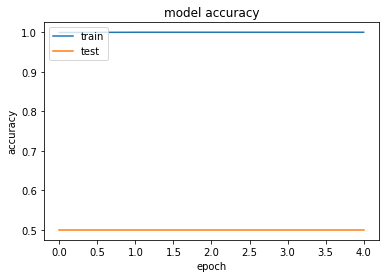

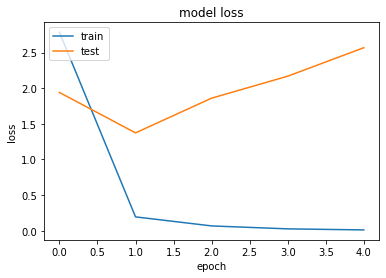

In [80]:
# list all data in history
print(model_cnn_tanh.history.history.keys())
# summarize history for accuracy
plt.plot(model_cnn_tanh.history.history['accuracy'])
plt.plot(model_cnn_tanh.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_cnn_tanh.history.history['loss'])
plt.plot(model_cnn_tanh.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 4:Hierarchical Recurrent Neural Networks


In [98]:
# Training parameters.
batch_size = 64
num_classes = 2
epochs = 3

# Embedding dimensions.
row_hidden = 32
col_hidden = 32


row, col, pixel = x_train.shape[1:]

# 4D input.
x = Input(shape=(row, col, pixel))

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(LSTM(row_hidden))(x)

# Encodes columns of encoded rows.
encoded_columns = LSTM(col_hidden)(encoded_rows)

# Final predictions and model.
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model_hrnn = Model(x, prediction)
model_hrnn.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training.
model_hrnn.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# Evaluation.
scores = model_hrnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 55342 samples, validate on 23390 samples
Epoch 1/3
55342/55342 [==============================] - 527s 10ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 9.4285 - val_accuracy: 0.5000
Epoch 2/3
55342/55342 [==============================] - 532s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.8968 - val_accuracy: 0.5000
Epoch 3/3
55342/55342 [==============================] - 536s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 10.1381 - val_accuracy: 0.5000
Test loss: 10.138056203410788
Test accuracy: 0.5


### Plotting Accuracy and Loss

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


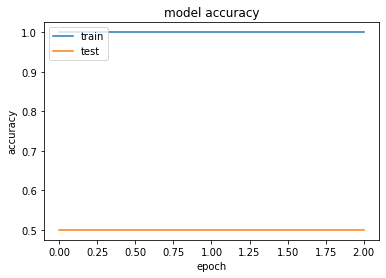

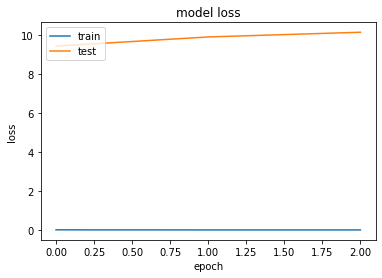

In [99]:
# list all data in history
print(model_hrnn.history.history.keys())
# summarize history for accuracy
plt.plot(model_hrnn.history.history['accuracy'])
plt.plot(model_hrnn.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_hrnn.history.history['loss'])
plt.plot(model_hrnn.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Data Augmentation

So far, all of our models have been overfitting. They've been unable to differentiate different tissue to identify whether an image contains traces of cancer. Data augmentation will allow me to slightly modify the images in a last-ditch effort to train a model that can classify images and diagnose breast cancer.

In [116]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = .2)
test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = .2)

In [117]:
training_set = train_datagen.flow_from_directory('C:\\Users\\M246047\\Documents\\Python\\breast_tissue_train',
                                       target_size=(50, 50),
                                                batch_size=32,
                                     class_mode='categorical',
                                            subset='training',
                                            color_mode='grayscale')

validation_set = test_datagen.flow_from_directory('C:\\Users\\M246047\\Documents\\Python\\breast_tissue_test',
                                        target_size=(50, 50),
                                                 batch_size=32,
                                      class_mode='categorical',
                                               shuffle = False,
                                           subset='validation',
                                             color_mode='grayscale')

Found 86287 images belonging to 2 classes.
Found 7018 images belonging to 2 classes.


### Models 6: CNN with TanH Activation

This is the first model to assign two different classes. It's pretty decent at correctly classifying images without cancerous tissue with a success rate of 87.5%, but labels cancerous tissue correctly less than two-thirds of the time. Hopefully I can tune this mode for better metrics.

In [156]:
# Building the Model
num_classes = 2
model_6 = Sequential()
# First convolutional layer, note the specification of shape
model_6.add(Conv2D(32, kernel_size=(3, 3),
                 activation='tanh',
                 input_shape=input_shape))
model_6.add(Conv2D(64, (4, 4), activation='tanh'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))
# model_6.add(Dropout(0.5))
model_6.add(Flatten())
# model_6.add(Dense(50, activation='relu'))
model_6.add(Dropout(0.5))
model_6.add(Dense(num_classes, activation='softmax'))

model_6.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(learning_rate=0.01),
              metrics=['accuracy'])

model_6.fit_generator(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=5,
                    validation_data=validation_set,
                    validation_steps=len(validation_set))

# Evaluation.
scores = model_6.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])



Epoch 1/5
2697/2697 [==============================] - 579s 215ms/step - loss: 0.5107 - accuracy: 0.7525 - val_loss: 1.6177 - val_accuracy: 0.6830
Epoch 2/5
2697/2697 [==============================] - 676s 251ms/step - loss: 0.4803 - accuracy: 0.7701 - val_loss: 1.6215 - val_accuracy: 0.7096
Epoch 3/5
2697/2697 [==============================] - 810s 300ms/step - loss: 0.4768 - accuracy: 0.7731 - val_loss: 1.6577 - val_accuracy: 0.7170
Epoch 4/5
2697/2697 [==============================] - 972s 360ms/step - loss: 0.4754 - accuracy: 0.7738 - val_loss: 1.2254 - val_accuracy: 0.8403
Epoch 5/5
2697/2697 [==============================] - 791s 293ms/step - loss: 0.4740 - accuracy: 0.7740 - val_loss: 1.2635 - val_accuracy: 0.8393
Test loss: 0.5188566839429954
Test accuracy: 0.7592560648918152


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


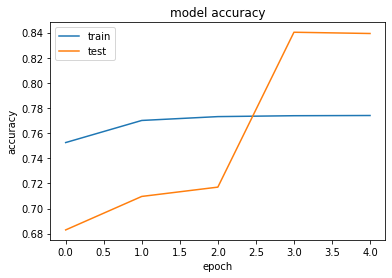

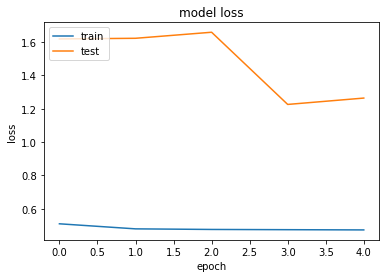

In [157]:
# list all data in history
print(model_6.history.history.keys())
# summarize history for accuracy
plt.plot(model_6.history.history['accuracy'])
plt.plot(model_6.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_6.history.history['loss'])
plt.plot(model_6.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [158]:
model_6_predictions = model_6.predict(x_test)
y_pred = (model_6_predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[10229,  1466],
       [ 4165,  7530]], dtype=int64)

|| Class 1 Predicted | Class 2 Predicted   |
|------|------|------|
Actual Class 1| 10,229 | 1,466 |       
Actual Class 2 | 4,165 | 7,530 |   

|| Class 1 Predicted | Class 2 Predicted   |
|------|------|------|
Actual Class 1| 87.5% (True Positive)| 11.5% (False Positive) |
Actual Class 2 | 35.6% (False Negative) | 64.4% (True Negative)|



### Model 7: 

In [162]:
# Building the Model
num_classes = 2
model_7 = Sequential()
# First convolutional layer, note the specification of shape
model_7.add(Conv2D(32, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))

model_7.add(Conv2D(64, (4, 4), activation='relu'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

model_7.add(Flatten())
model_7.add(Dense(128, activation='relu'))

model_7.add(Dense(num_classes, activation='softmax'))

model_7.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_7.fit_generator(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=10,
                    validation_data=validation_set,
                    validation_steps=len(validation_set))

# Evaluation.
scores = model_7.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/10
2697/2697 [==============================] - 798s 296ms/step - loss: 0.4918 - accuracy: 0.7682 - val_loss: 1.5072 - val_accuracy: 0.6760
Epoch 2/10
2697/2697 [==============================] - 881s 327ms/step - loss: 0.4734 - accuracy: 0.7797 - val_loss: 1.6373 - val_accuracy: 0.6995
Epoch 3/10
2697/2697 [==============================] - 908s 337ms/step - loss: 0.4599 - accuracy: 0.7899 - val_loss: 1.6825 - val_accuracy: 0.8464
Epoch 4/10
2697/2697 [==============================] - 1054s 391ms/step - loss: 0.4480 - accuracy: 0.7996 - val_loss: 1.9408 - val_accuracy: 0.8045
Epoch 5/10
2697/2697 [==============================] - 1127s 418ms/step - loss: 0.4371 - accuracy: 0.8068 - val_loss: 1.5088 - val_accuracy: 0.7475
Epoch 6/10
2697/2697 [==============================] - 867s 322ms/step - loss: 0.4312 - accuracy: 0.8116 - val_loss: 1.6767 - val_accuracy: 0.8601
Epoch 7/10
2697/2697 [==============================] - 995s 369ms/step - loss: 0.4272 - accuracy: 0.8114 - va

In [94]:
# Evaluation.
scores = model_7.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.48022514636850905
Test accuracy: 0.7762719392776489


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


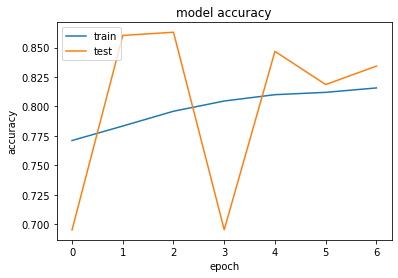

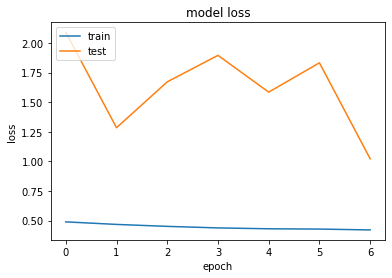

In [119]:
# list all data in history
print(model_7.history.history.keys())
# summarize history for accuracy
plt.plot(model_7.history.history['accuracy'])
plt.plot(model_7.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_7.history.history['loss'])
plt.plot(model_7.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [125]:
model_7_predictions = model_7.predict(x_test)
y_pred = (model_7_predictions > 0.5)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[9289, 2406],
       [2342, 9353]], dtype=int64)

# Model 8: Playing with Callbacks

In [160]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Building the Model
num_classes = 2
model_8 = Sequential()
# First convolutional layer, note the specification of shape
model_8.add(Conv2D(32, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))
model_8.add(Conv2D(64, (4, 4), activation='relu'))
model_8.add(MaxPooling2D(pool_size=(2, 2)))
# model_7.add(Dropout(0.25))
model_8.add(Flatten())
model_8.add(Dense(128, activation='relu'))
# model_7.add(Dropout(0.5))
model_8.add(Dense(num_classes, activation='softmax'))

model_8.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(learning_rate=0.001),
              metrics=['accuracy'])

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]

history_8 = model_8.fit_generator(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=20,
                    callbacks=callbacks,
                    validation_data=validation_set,
                    validation_steps=len(validation_set))

# Evaluation.
scores = model_8.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/20
2697/2697 [==============================] - 948s 351ms/step - loss: 0.5362 - accuracy: 0.7434 - val_loss: 1.5357 - val_accuracy: 0.6667
Epoch 2/20
2697/2697 [==============================] - 991s 367ms/step - loss: 0.5242 - accuracy: 0.7432 - val_loss: 1.6028 - val_accuracy: 0.6667
Epoch 3/20
2697/2697 [==============================] - 1096s 406ms/step - loss: 0.5121 - accuracy: 0.7434 - val_loss: 1.5375 - val_accuracy: 0.6724
Epoch 4/20
2697/2697 [==============================] - 864s 320ms/step - loss: 0.5012 - accuracy: 0.7479 - val_loss: 1.4605 - val_accuracy: 0.6780
Epoch 5/20
2697/2697 [==============================] - 832s 309ms/step - loss: 0.4932 - accuracy: 0.7573 - val_loss: 1.5694 - val_accuracy: 0.6790
Epoch 6/20
2697/2697 [==============================] - 963s 357ms/step - loss: 0.4868 - accuracy: 0.7662 - val_loss: 1.5721 - val_accuracy: 0.6820
Epoch 7/20
2697/2697 [==============================] - 955s 354ms/step - loss: 0.4828 - accuracy: 0.7708 - val

KeyboardInterrupt: 

In [136]:
X = np.concatenate((X_0, X_1, X_0_test, X_1_test), axis=0)
y = np.concatenate((X_0_target, X_1_target, X_0_test_target, X_1_test_target), axis=0)
X = X.reshape(78732,2500)
X = pd.DataFrame(X)
X['y'] = y
X.shape

(78732, 2501)

# Dimensionality Reduction

## PCA

In [170]:
# We just want the first two principal components
pca = PCA(n_components=2)

# We get the components by 
# calling fit_transform method with our data
pca_components = pca.fit_transform(X[:50])
print(pca_components)

[[-1066.68428693   617.64277781]
 [  330.11411707   -96.08136185]
 [ 1602.561731     230.34004705]
 [ 1715.81922891    24.36952889]
 [ 1263.22412389  1670.81155242]
 [-1836.91841928   999.04049585]
 [-1883.62233765  -366.7959417 ]
 [  961.03596127   -36.98340058]
 [ 2242.87475987   755.39403162]
 [ 1232.56072062  -813.09834953]
 [ 1866.80066191   177.9463982 ]
 [ -190.72704714   261.5590886 ]
 [-1681.78698202   157.20027734]
 [-1803.29685905    15.89948321]
 [-1425.07882573   -14.97203609]
 [ -734.28652845  -190.65994492]
 [-1100.04746997   -53.719005  ]
 [ -997.18665325   135.59709369]
 [ -962.13580575  -389.74994026]
 [  696.37839177  -135.48805903]
 [ 1910.33280552  -774.39731349]
 [ 1376.04906445   925.49525381]
 [ -445.38035067  -124.84380529]
 [   84.2200633    194.51326305]
 [ -957.7099237    228.33466166]
 [ -109.26275374  1570.64657947]
 [-1635.83675666   142.66744152]
 [-1735.08889022  -976.38706966]
 [  598.53939381 -1595.99279211]
 [ 1749.6870239   -272.65182528]
 [ 1056.12

In [173]:
pca_components.shape[0]

50

In [174]:
plt.figure(figsize=(10,5))
colours = ["r","b"]
for i in range(pca_components.shape[0]):
    plt.text(pca_components[i, 0], pca_components[i, 1], str(y[i]),
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
# plt.axis('off')
plt.show()

ValueError: Image size of 2302634x887979 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x360 with 1 Axes>

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## t-SNE

In [12]:
for perplexity in [10, 20, 30, 40]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(X)
    print('Cluster Graph with t-SNE with Perplexity ', perplexity)

#     plt.figure(figsize=(8,3))
#     plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
#     plt.xticks([])
#     plt.yticks([])
#     plt.axis('off')
#     plt.show()
    
    plt.figure(figsize=(10,5))
    colours = ["r","b"]
    for i in range(tsne_results.shape[0]):
        plt.text(tsne_results[i, 0], tsne_results[i, 1], str(y[i]),
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 5}
        )

    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2743 samples in 0.475s...
[t-SNE] Computed neighbors for 2743 samples in 66.683s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2743
[t-SNE] Computed conditional probabilities for sample 2000 / 2743
[t-SNE] Computed conditional probabilities for sample 2743 / 2743
[t-SNE] Mean sigma: 1.505131
[t-SNE] KL divergence after 250 iterations with early exaggeration: 124.958084
[t-SNE] KL divergence after 300 iterations: 4.538259
Cluster Graph with t-SNE with Perplexity  10


ValueError: Image size of 1255441x277357 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x360 with 1 Axes>

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2743 samples in 0.429s...


KeyboardInterrupt: 

In [55]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(tsne_results.shape)
tsne_results

(2743, 2)


array([[ 4.58334160e+00,  8.82671356e+00],
       [-1.06564844e+00,  1.40423470e+01],
       [ 4.86538458e+00,  7.32337952e+00],
       [-3.54867053e+00,  4.39731836e+00],
       [ 2.47505617e+00,  6.72055435e+00],
       [ 1.69942260e+00,  6.72903442e+00],
       [-3.43832880e-01,  4.69144964e+00],
       [ 5.10715199e+00,  4.81673431e+00],
       [-5.92665300e-02,  8.25024319e+00],
       [ 3.14192128e+00,  6.86266184e+00],
       [-5.87384164e-01,  1.07485762e+01],
       [-1.45011842e+00,  3.86410785e+00],
       [-2.49221087e+00,  4.91301107e+00],
       [ 7.98016846e-01, -1.44322729e+00],
       [-4.37574959e+00,  9.20782447e-01],
       [-3.18429589e+00, -7.26211262e+00],
       [ 4.56833076e+00,  2.02394109e-02],
       [ 7.19220018e+00, -5.79629612e+00],
       [ 2.78780508e+00,  4.31465101e+00],
       [ 1.05401289e+00,  6.24702740e+00],
       [-4.00464010e+00, -8.95143700e+00],
       [ 2.01593256e+00,  8.60271931e+00],
       [ 1.25666142e+00,  7.97984076e+00],
       [ 1.

In [60]:
np.save('labels.npy', y)

In [50]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print(tsne_results)
plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], str(y[i]),
             color=colours[int(y[i])],
             fontdict={'weight': 'bold', 'size': 10}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2743 samples in 0.255s...
[t-SNE] Computed neighbors for 2743 samples in 35.994s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2743
[t-SNE] Computed conditional probabilities for sample 2000 / 2743
[t-SNE] Computed conditional probabilities for sample 2743 / 2743
[t-SNE] Mean sigma: 2.006664
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.162865
[t-SNE] KL divergence after 300 iterations: 2.845817
[[ 4.5833416e+00  8.8267136e+00]
 [-1.0656484e+00  1.4042347e+01]
 [ 4.8653846e+00  7.3233795e+00]
 ...
 [ 3.9903036e-01  3.6138432e+00]
 [-7.2486916e+00  2.4219985e+00]
 [-6.1923079e+00 -1.0170504e-02]]


ValueError: Image size of 225578x93218 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x360 with 1 Axes>

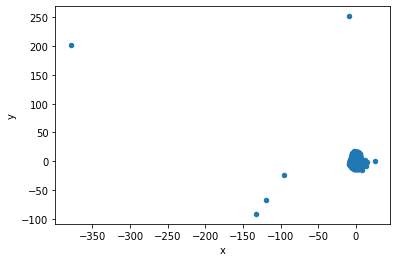

In [58]:
tsne_as_df = pd.DataFrame(tsne_results, columns=['x', 'y'])
tsne_as_df.plot(kind='scatter', x='x', y='y')

## UMAP

UMAP with all features. 

UMAP for X_all with  5 neighbors and  0.1 minimum distance.


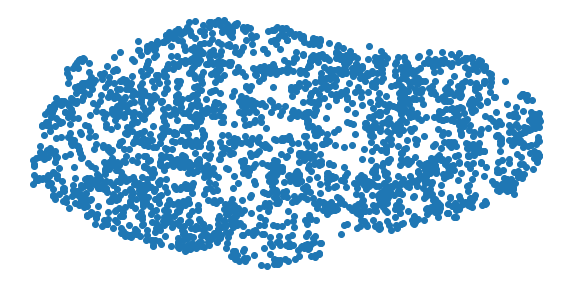



UMAP for X_all with  5 neighbors and  0.25 minimum distance.


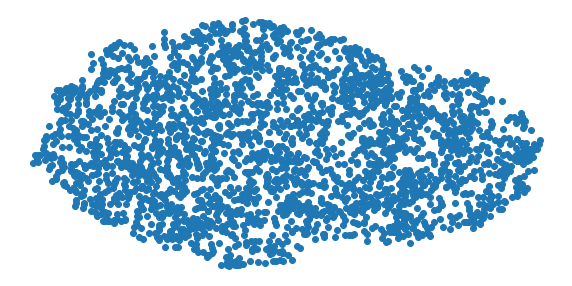



UMAP for X_all with  10 neighbors and  0.1 minimum distance.


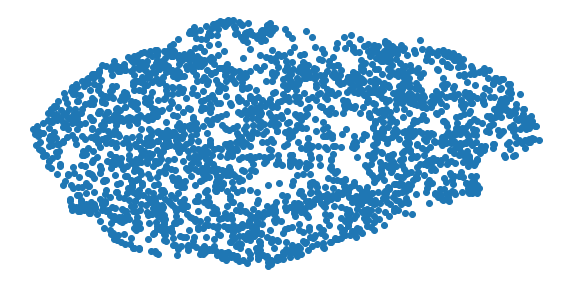



UMAP for X_all with  10 neighbors and  0.25 minimum distance.


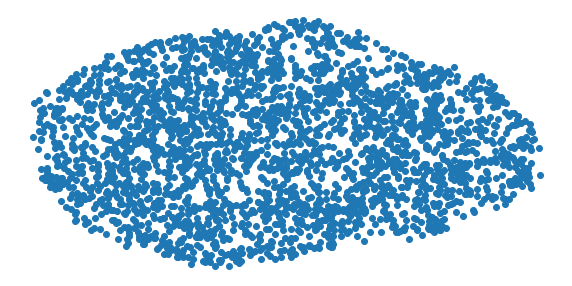

In [13]:
# UMAP with all features
print('UMAP with all features. \n')
for n_neighbors in [5, 10]:
    for min_dist in [0.1, 0.25]:
        umap_results = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=min_dist,
                      metric='correlation').fit_transform(X)
        print('UMAP for X with ', n_neighbors, 'neighbors and ', min_dist, 'minimum distance.')
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()
        print('\n')

## Functions to Add Cluster Labels

For each clustering technique, I'll create a function to run it. I'll use lists and dictionaries to compare parameters (cluster numbers, eps, etc.), so I've also created a function (getKeysByValue) that will allow me to obtain a dictionary key by its value. Additionally, I've created two functions that will obtain the p-values for all variables once clusters have been assigned. One will be used when a clustering technique provides two clusters, and the other for three.

In [18]:

# Get a list of keys from dictionary which has the given value

def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys

import operator

def get_pvalue_2clusters(variables):
    variables_pvalues = {}
    for variable in variables:
        t, pvalue = stats.ttest_ind(group_0[[variable]], group_1[[variable]])
        variables_pvalues[variable] = pvalue
    sorted_variables_pvalues = sorted(variables_pvalues.items(), key=operator.itemgetter(1))
    for variable, pvalue in sorted_variables_pvalues:
        print(variable, ':', pvalue)

def get_pvalue_3clusters(variables):
    variables_pvalues = {}
    for variable in variables:
        stat, pvalue = stats.f_oneway(group_0[[variable]], group_1[[variable]], group_2[[variable]])
        variables_pvalues[variable] = pvalue
    sorted_variables_pvalues = sorted(variables_pvalues.items(), key=operator.itemgetter(1))
    for variable, pvalue in sorted_variables_pvalues:
        print(variable, ':', pvalue)

# Clustering
## K-means Function
All functions will be able to use data with either PCA or UMAP components and additional parameters when needed. They will iterate through a set number of clusters (or other parameter), graph the silhouette scores, and plot the clusters when able. I have also chosen to show the Davies Bouldin index as another clustering metric to compare.

In [20]:
def kmeans_clustering(df, dr_technique, **params):    
    clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    silhouettes_list = []
    silhouettes_dict = {} # silhoutte scores are keys, clusters are values
    dbs = []      
       
   
    if dr_technique=='PCA':
        pca = PCA(n_components=2)
        components = pca.fit_transform(df)
       
    elif dr_technique=='UMAP': 
        parameters = list(params.keys())
        number_of_neighbors = params[parameters[0]]
        min_distance = params[parameters[1]]
        components = umap.UMAP(n_neighbors=number_of_neighbors, min_dist=min_distance, metric='correlation').fit_transform(df)

    # looping through cluster numbers to find the best cluster
    for cluster in clusters:
        labels = KMeans(n_clusters=cluster, random_state=123).fit_predict(components)
        kmeans_cluster = KMeans(n_clusters=cluster, random_state=123)
        y_pred = kmeans_cluster.fit_predict(components)
        silhouette = metrics.silhouette_score(components, labels, metric='euclidean')
        silhouettes_list.append(silhouette)
        silhouettes_dict[cluster] = silhouette
        db = metrics.davies_bouldin_score(components, labels)
        dbs.append(db)

    # plotting the silhouette scores
    plt.title('Silhouette Scores for Number of Clusters')  
    plt.scatter(list(silhouettes_dict.keys()), list(silhouettes_dict.values()))
    plt.show()


    best_cluster = getKeysByValue(silhouettes_dict, max(silhouettes_list))
    best_cluster_dbi = metrics.davies_bouldin_score(components,  KMeans(n_clusters=best_cluster[0], random_state=123).fit_predict(components))
    print('Best Silhouette score is {} with {} clusters. '.format( silhouettes_dict[best_cluster[0]],best_cluster[0]))
    print('Best Davies Bouldin score: ', min(dbs))   
    # plotting the clusters with the best silhouette score
    labels = KMeans(n_clusters=best_cluster[0], random_state=123).fit_predict(components)
    kmeans_cluster = KMeans(n_clusters=best_cluster[0], random_state=123)
    y_pred = kmeans_cluster.fit_predict(components)
     
    plt.figure(figsize=(10,5))
    plt.title('K-Means Clustering for {} Clusters with Davies Bouldin Index {}'.format(best_cluster[0], best_cluster_dbi))
    plt.scatter(components[:,0], components[:,1], c=y_pred)
    plt.show()

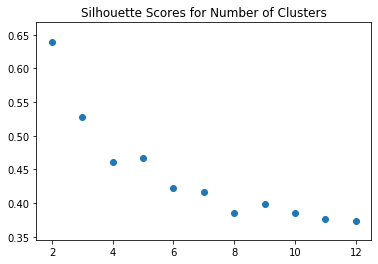

Best Silhouette score is 0.6397907999401276 with 2 clusters. 
Best Davies Bouldin score:  0.4956891348221909


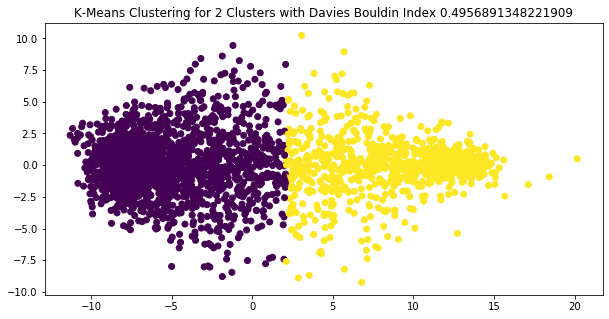

In [21]:
kmeans_clustering(X, 'PCA')

## P-Values for Labeled Features
For each round of clustering, I will assign cluster labels to the highest performer, find the p-values between clusters, and graph the results. In this round, using PCA components for the features highly correlated with humansDeaths was the top performer.

In [59]:
# K-means

pca = PCA(n_components=2)
components = pca.fit_transform(X)

labels = KMeans(n_clusters=2, random_state=123).fit_predict(components)
print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_pca_kmeans_clusters'] = labels
group_0 = X[X['X_pca_kmeans_clusters'] == 0]
group_1 = X[X['X_pca_kmeans_clusters'] == 1]

get_pvalue_2clusters(X.columns)

(2743, 2500)
2743
{0: 1762, 1: 981}


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Cluster Labels for humansDeaths features with PCA Components

In [ ]:
# Agglomerative Clustering with humansDeaths features

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_hd)

agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)
labels = agg_cluster.fit_predict(umap_results)
print(X.shape)
print(len(labels))
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
X['X_hd_agg_clusters'] = labels
group_0 = X[X['X_hd_agg_clusters'] == 0]
group_1 = X[X['X_hd_agg_clusters'] == 1]

get_pvalue_2clusters(X.columns)

## Agglomerative Clustering for all features with PCA Components

In [23]:
def agglomerative_clustering(df, dr_technique, **params):
    clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    dbs = []      
       

    if dr_technique=='PCA':
        pca = PCA(n_components=2)
        components = pca.fit_transform(df)
       
    elif dr_technique=='UMAP': 
        parameters = list(params.keys())
        number_of_neighbors = params[parameters[0]]
        min_distance = params[parameters[1]]
        components = umap.UMAP(n_neighbors=number_of_neighbors, min_dist=min_distance, metric='correlation').fit_transform(df)

    # looping through cluster numbers to find the best cluster
    silhouettes_ward = {} # clusters are keys, silhoutte scores are values
    silhouettes_ward_list = []
    for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='ward',
                                      affinity='euclidean',
                                      n_clusters=cluster)
        labels = agg_cluster.fit_predict(components)
        silhouette = metrics.silhouette_score(components, labels, metric='euclidean')
        silhouettes_ward_list.append(silhouette)
        silhouettes_ward[cluster] = silhouette
        db = metrics.davies_bouldin_score(components, labels)
        dbs.append(db)
        
     
    silhouettes_complete = {} # silhoutte scores are keys, clusters are values
    silhouettes_complete_list = []
    for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='complete',
                                      affinity='euclidean',
                                      n_clusters=cluster)
        labels = agg_cluster.fit_predict(components)
        silhouette = metrics.silhouette_score(components, labels, metric='euclidean')
        silhouettes_complete_list.append(silhouette)
        silhouettes_complete[cluster] = silhouette
        db = metrics.davies_bouldin_score(components, labels)
        dbs.append(db)
       
    silhouettes_average = {} # silhoutte scores are keys, clusters are values
    silhouettes_average_list = []
    for cluster in clusters:
        agg_cluster = AgglomerativeClustering(linkage='average',
                                      affinity='euclidean',
                                      n_clusters=cluster)
        labels = agg_cluster.fit_predict(components)
        silhouette = metrics.silhouette_score(components, labels, metric='euclidean')
        silhouettes_average_list.append(silhouette)
        silhouettes_average[cluster] = silhouette
        db = metrics.davies_bouldin_score(components, labels)
        dbs.append(db)
       
    best_ward_cluster = getKeysByValue(silhouettes_ward, max(silhouettes_ward_list))
    best_ward_cluster = best_ward_cluster[0]
    best_complete_cluster = getKeysByValue(silhouettes_complete, max(silhouettes_complete_list))
    best_complete_cluster = best_complete_cluster[0]
    best_average_cluster = getKeysByValue(silhouettes_average, max(silhouettes_average_list))
    best_average_cluster = best_average_cluster[0]
    # plotting the silhouette scores
    plt.title('Silhouette Scores for Number of Clusters')  
    plt.scatter(list(silhouettes_ward.keys()), list(silhouettes_ward.values()), color='blue')
    plt.scatter(list(silhouettes_complete.keys()), list(silhouettes_complete.values()), color='green')
    plt.scatter(list(silhouettes_average.keys()), list(silhouettes_average.values()), color='red')
    plt.show()

    print('Best Silhouette score with ward linkage is {} with {} clusters. '.format(silhouettes_ward[best_ward_cluster], best_ward_cluster))
    print('Best Silhouette score with complete linkage is {} with {} clusters. '.format(silhouettes_complete[best_complete_cluster], best_complete_cluster))
    print('Best Silhouette score with average linkage is {} with {} clusters. '.format(silhouettes_average[best_average_cluster], best_average_cluster))
    print('Best Davies Bouldin score: ', min(dbs))

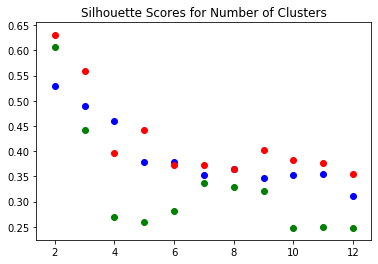

Best Silhouette score with ward linkage is 0.5287492848617209 with 2 clusters. 
Best Silhouette score with complete linkage is 0.6075589537533723 with 2 clusters. 
Best Silhouette score with average linkage is 0.6302970144918172 with 2 clusters. 
Best Davies Bouldin score:  0.4627621238727491


In [24]:
agglomerative_clustering(X, 'PCA')

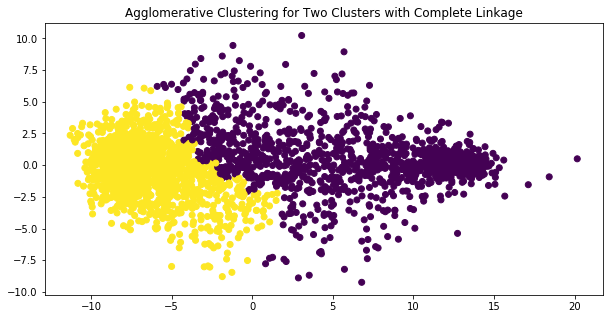

Silhouette Score:  0.5287492847432582
Davies Bouldin Index:  0.6460887845606447


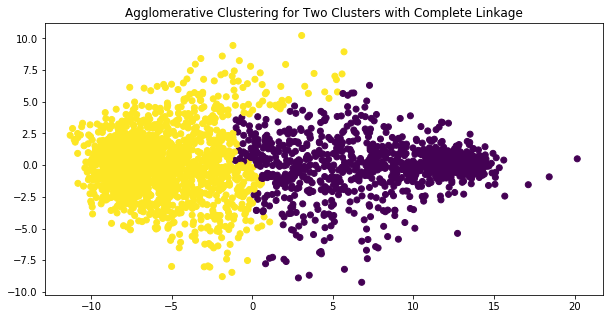

Silhouette Score:  0.6075589536280048
Davies Bouldin Index:  0.5477914464388166


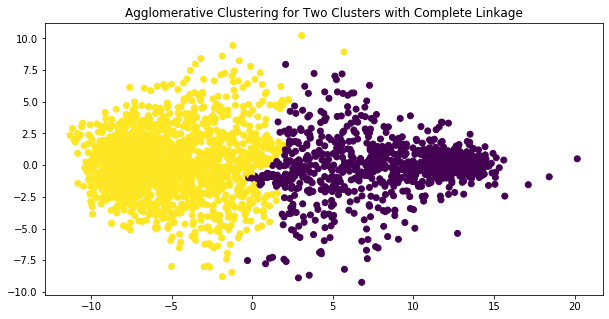

Silhouette Score:  0.6302970144778901
Davies Bouldin Index:  0.5151345708932683


In [27]:
# plotting the clusters with the best silhouette score
for link in ['ward', 'complete', 'average']:
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(X)
    agg_cluster = AgglomerativeClustering(linkage=link, 
                                      affinity='euclidean',
                                      n_clusters=2)
    cluster_labels = agg_cluster.fit_predict(pca_components)
    
    plt.figure(figsize=(10,5))
    plt.title('Agglomerative Clustering for Two Clusters with Complete Linkage')
    plt.scatter(pca_components[:,0], pca_components[:,1], c=cluster_labels)
    plt.show()

    print('Silhouette Score: ', metrics.silhouette_score(pca_components, cluster_labels, metric='euclidean'))
    print('Davies Bouldin Index: ', metrics.davies_bouldin_score(pca_components, cluster_labels))

## DBSCAN with PCA Components

In [28]:
def dbscan_find_clusters(eps, min_samples, X):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    num_labels = len(set(labels))
    num_samples = X.shape[0]
    silhouettes_dbscan = {}
    if num_labels == 1 or num_labels == num_samples:
          silhouette = -1
          silhouettes_dbscan[silhouette] = min_samples
          print('{} min samples and {} eps have no clusters.'.format(min_samples, eps))
    else:
          silhouette = metrics.silhouette_score(X, labels)
          print('{} min samples and {} eps have {} silhouette score with {} clusters.'.format(min_samples, eps, silhouette, num_labels))
          return {
            'eps': eps,
            'min_samples': min_samples,
            'silhouette_score': silhouette,
            'davies_bouldin': metrics.davies_bouldin_score(X, labels)
            }
          silhouettes_dbscan[silhouette] = min_samples
    plt.figure(figsize=(10,5))
    plt.title('Silhouette Scores for {} eps'.format(eps))
    plt.scatter(list(silhouettes_dbscan.values()), list(silhouettes_dbscan.keys()), color='blue')
    plt.xlabel('Min Samples')
    plt.ylabel('Silhouette Score')

## DBSCAN with All Features with PCA Components¶

In [29]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

results = [dbscan_find_clusters(eps, min_samples, pca_components) for eps in [0.5, 1, 2] for min_samples in [5,10,15,20]]

5 min samples and 0.5 eps have -0.5545030784450975 silhouette score with 19 clusters.
10 min samples and 0.5 eps have 0.023132608757187385 silhouette score with 8 clusters.
15 min samples and 0.5 eps have -0.08927419381621746 silhouette score with 10 clusters.
20 min samples and 0.5 eps have 0.1052678474927515 silhouette score with 4 clusters.
5 min samples and 1 eps have -0.02150946863130209 silhouette score with 5 clusters.
10 min samples and 1 eps have -0.03882014264968592 silhouette score with 3 clusters.
15 min samples and 1 eps have 0.1048563974889016 silhouette score with 2 clusters.
20 min samples and 1 eps have 0.09453617694167527 silhouette score with 2 clusters.
5 min samples and 2 eps have 0.3305918433996795 silhouette score with 2 clusters.
10 min samples and 2 eps have 0.25971064393709603 silhouette score with 2 clusters.
15 min samples and 2 eps have 0.24930701842576103 silhouette score with 2 clusters.
20 min samples and 2 eps have 0.23969545836528774 silhouette score w

# HDBSCAN with PCA Components

In [ ]:
def hdbscan_find_clusters(eps, min_samples, X):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    num_labels = len(set(labels))
    num_samples = X.shape[0]
    silhouettes_dbscan = {}
    if num_labels == 1 or num_labels == num_samples:
          silhouette = -1
          silhouettes_dbscan[silhouette] = min_samples
          print('{} min samples and {} eps have no clusters.'.format(min_samples, eps))
    else:
          silhouette = metrics.silhouette_score(X, labels)
          print('{} min samples and {} eps have {} silhouette score with {} clusters.'.format(min_samples, eps, silhouette, num_labels))
          return {
            'eps': eps,
            'min_samples': min_samples,
            'silhouette_score': silhouette,
            'davies_bouldin': metrics.davies_bouldin_score(X, labels)
            }
          silhouettes_dbscan[silhouette] = min_samples
    plt.figure(figsize=(10,5))
    plt.title('Silhouette Scores for {} eps'.format(eps))
    plt.scatter(list(silhouettes_dbscan.values()), list(silhouettes_dbscan.keys()), color='blue')
    plt.xlabel('Min Samples')
    plt.ylabel('Silhouette Score')

In [31]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(X)
clusterer.labels_
clusterer.labels_.max()

1

In [33]:
clusterer = hdbscan.HDBSCAN(metric='manhattan')
clusterer.fit(X)
clusterer.labels_
clusterer.labels_.max()

1